In [1]:
import jax
import jax.numpy as np
import flax.linen as nn
import optax
import diffrax as dfx


from typing import Sequence, Callable
import tensorflow_probability.substrates.jax as tfp
from tqdm import trange

tfd = tfp.distributions

## The dataset

(-2.0, 2.0)

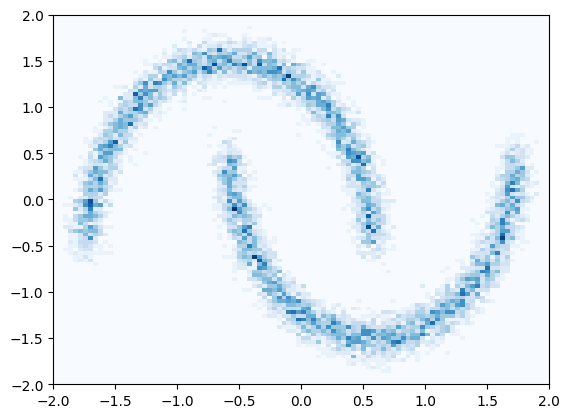

In [29]:
from sklearn import datasets, preprocessing
import matplotlib.pyplot as plt

n_samples = 10_000

x, _ = datasets.make_moons(n_samples=n_samples, noise=.06)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100, cmap='Blues', range=[[-2, 2], [-2, 2]])
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

## The flow

In [20]:
class MLP(nn.Module):
    """A simple MLP (fully-connected neural network)."""

    feature_sizes: Sequence[int]
    activation: Callable[[np.ndarray], np.ndarray] = nn.gelu

    @nn.compact
    def __call__(self, x, t):
        
        x = np.concatenate([x, t], axis=-1)
        for features in self.feature_sizes[:-1]:
            x = nn.Dense(features)(x)
            x = self.activation(x)
            x = np.concatenate([x, t], axis=-1)
        x = nn.Dense(self.feature_sizes[-1])(x)
        return x


class SymplecticFlow(nn.Module):
    T: float = 2.0  # Total time
    dt: float = 5e-2  # Time step
    solver: dfx.AbstractSolver = dfx.LeapfrogMidpoint()  # Diffrax solver
    n_transforms: int = 3  # Number of flow transforms
    d_hidden: int = 64  # Hidden dims of MLP
    n_layers: int = 2  # Hidden layers in MLP
    n_dim: int = 2  # Parameter dim

    def setup(self):
        self.potential_funcs = [MLP([self.d_hidden] * self.n_layers + [1]) for _ in range(self.n_transforms)]
        self.stepsize_controller = dfx.ConstantStepSize() if type(self.solver) is dfx.LeapfrogMidpoint else dfx.PIDController(atol=1e-4, rtol=1e-4)    

    def dxdt(self, t, xv, args):
        params, i = args
        x, v = xv
        return (v, np.zeros_like(v))  # dx/dt = v

    def dvdt(self, t, xv, args):
        params, i = args
        x, v = xv
        potential = lambda x: self.potential_funcs[i].apply({'params': params}, x, np.atleast_1d(t))[0]
        grad_potential = jax.grad(potential)
        return (np.zeros_like(x), -grad_potential(x))  # dv/dt = a =-grad(potential)

    def log_prob(self, xv):
        """ Log-probability of flow for a single sample `xv`."""

        if self.is_initializing():
            x, v = np.split(xv, 2, axis=-1)
            for i in range(self.n_transforms):
                self.potential_funcs[i](x, np.atleast_1d(0.0))

        ode_params = [potential_func.variables['params'] for potential_func in self.potential_funcs]

        # Base distribution is just a standard normal
        base_dist = tfd.MultivariateNormalDiag(loc=np.zeros_like(xv), scale_diag=np.ones_like(xv))

        pos, vel = np.split(xv, 2, axis=-1)

        for i in range(self.n_transforms):

            y0 = (pos, vel)
            terms = dfx.MultiTerm(dfx.ODETerm(self.dxdt), dfx.ODETerm(self.dvdt))
            
            sol = dfx.diffeqsolve(terms, self.solver, self.T, 0.0, -self.dt, y0=y0, args=(ode_params[i], i), stepsize_controller=self.stepsize_controller)
            
            pos, vel = sol.ys
            pos, vel = pos[0], vel[0]            

        xv = np.concatenate([pos, vel], axis=-1)

        # Compute log-density
        log_prob = base_dist.log_prob(xv)

        return log_prob

    def sample_single(self, key):
        """ Single sample from the flow."""

        key, subkey = jax.random.split(key)
        xv = jax.random.normal(subkey, shape=(self.n_dim,))

        pos, vel = np.split(xv, 2, axis=-1)

        ode_params = [potential_func.variables['params'] for potential_func in self.potential_funcs]

        # Forward flow
        for i in range(self.n_transforms - 1, -1, -1):

            y0 = (pos, vel)
            terms = dfx.MultiTerm(dfx.ODETerm(self.dxdt), dfx.ODETerm(self.dvdt))

            sol = dfx.diffeqsolve(terms, self.solver, 0.0, self.T, self.dt, y0=y0, args=(ode_params[i], i), stepsize_controller=self.stepsize_controller)
            pos, vel = sol.ys
            pos, vel = pos[0], vel[0]

        return np.concatenate([pos, vel], axis=-1)

    def sample(self, key, n_samples):
        """ Batch of samples from the flow."""
        sample_key = jax.random.split(key, n_samples ** 2)
        return jax.vmap(self.sample_single)(sample_key)
    
    def __call__(self, x):
        """Batched log-prob."""
        return jax.vmap(self.log_prob)(x)

In [10]:
flow = SymplecticFlow()
xv = jax.random.normal(jax.random.PRNGKey(0), (100, 2))

rng = jax.random.PRNGKey(0)
log_prob, params = flow.init_with_output(rng, xv)

In [21]:
# Sample
flow.apply(params, rng, 100, method=flow.sample);

## Train

In [22]:
opt = optax.sgd(learning_rate=3e-4, momentum=0.99, nesterov=True)
opt_state = opt.init(params)

In [13]:
@jax.jit
def loss_fn(params, x):
    log_prob = flow.apply(params, x)
    return -log_prob.mean()

In [14]:
n_steps = 3000
n_batch = 256

key = jax.random.PRNGKey(42)

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]
        
        loss, grads = jax.value_and_grad(loss_fn)(params, x_batch)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 3000/3000 [07:39<00:00,  6.53it/s, val=2.105539] 


## Sample

In [23]:
x_sample = flow.apply(params, rng, 1000, method=flow.sample)

Text(0.5, 1.0, 'Samples from the flow')

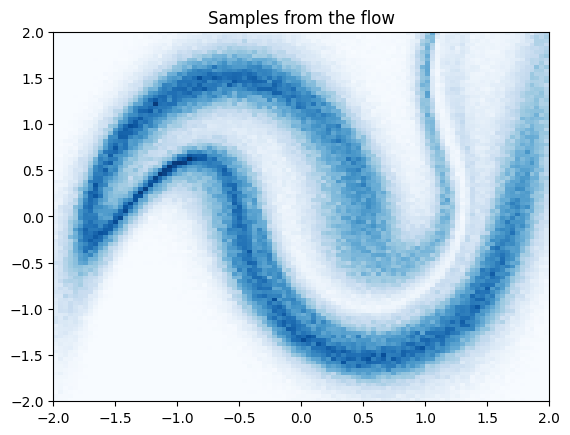

In [31]:
plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100, range=[[-2, 2], [-2, 2]], cmap='Blues');
plt.xlim(-2 ,2)
plt.ylim(-2, 2)
plt.title('Samples from the flow')